In [1]:
from tensorflow import keras
from keras.datasets import cifar10
from keras.utils import plot_model, to_categorical
from keras.models import Model
from keras import layers
import os
import numpy as np
import math

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


In [3]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42)

array([[[ 18,  12,  24],
        [ 22,  16,  28],
        [ 27,  21,  33],
        ...,
        [ 26,  19,  30],
        [ 14,  11,  18],
        [ 11,  10,  16]],

       [[ 18,  12,  24],
        [ 21,  15,  27],
        [ 25,  19,  31],
        ...,
        [ 27,  23,  32],
        [ 21,  21,  27],
        [ 17,  18,  24]],

       [[ 23,  17,  29],
        [ 22,  16,  28],
        [ 20,  14,  26],
        ...,
        [ 29,  28,  37],
        [ 25,  26,  32],
        [ 21,  25,  30]],

       ...,

       [[ 44,  24,  35],
        [ 48,  26,  38],
        [ 55,  31,  43],
        ...,
        [130, 131, 159],
        [105, 104, 127],
        [ 65,  60,  82]],

       [[ 25,  17,  27],
        [ 29,  21,  31],
        [ 38,  28,  38],
        ...,
        [125, 127, 155],
        [ 91,  89, 113],
        [ 49,  42,  64]],

       [[ 16,  13,  20],
        [ 19,  16,  24],
        [ 22,  18,  27],
        ...,
        [101, 100, 125],
        [ 55,  51,  72],
        [ 26,  19,  37]]], dtype=uint8)
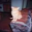

In [4]:
x_train[0]

In [5]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((45000, 32, 32, 3), (45000, 1), (5000, 32, 32, 3), (5000, 1))

In [6]:
x_train = x_train.astype("float32") / 255
x_test = x_test.astype('float32') / 255
x_val = x_val.astype("float32") / 255

# acording to the paper
mean = np.mean(x_train, axis=(0, 1, 2))
std = np.std(x_train, axis=(0, 1, 2))

x_train = (x_train - mean) / std
x_val = (x_val - mean) / std
x_test = (x_test - mean) / std

num_classes = 10

y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(45000, 32, 32, 3) (45000, 10)
(5000, 32, 32, 3) (5000, 10)
(10000, 32, 32, 3) (10000, 10)


In [7]:
x_train[0]

array([[[-1.7039003 , -1.7885957 , -1.3480684 ],
        [-1.6404057 , -1.724156  , -1.2881132 ],
        [-1.5610373 , -1.6436065 , -1.2131692 ],
        ...,
        [-1.576911  , -1.6758263 , -1.2581357 ],
        [-1.767395  , -1.8047056 , -1.438001  ],
        [-1.815016  , -1.8208154 , -1.4679786 ]],

       [[-1.7039003 , -1.7885957 , -1.3480684 ],
        [-1.6562793 , -1.740266  , -1.303102  ],
        [-1.5927846 , -1.6758263 , -1.2431469 ],
        ...,
        [-1.5610373 , -1.6113867 , -1.228158  ],
        [-1.6562793 , -1.6436065 , -1.303102  ],
        [-1.719774  , -1.6919363 , -1.3480684 ]],

       [[-1.624532  , -1.7080461 , -1.2731245 ],
        [-1.6404057 , -1.724156  , -1.2881132 ],
        [-1.672153  , -1.7563759 , -1.3180908 ],
        ...,
        [-1.52929   , -1.5308372 , -1.1532141 ],
        [-1.5927846 , -1.563057  , -1.228158  ],
        [-1.6562793 , -1.5791669 , -1.2581357 ]],

       ...,

       [[-1.2911849 , -1.5952767 , -1.1831917 ],
        [-1

In [22]:
def input_layer(input_shape, bottleneck = True, compression = True, k = 12):
  inputs = layers.Input(shape = input_shape)
  x = layers.BatchNormalization()(inputs)
  x = layers.Activation('relu')(x)
  if bottleneck and compression:
    x = layers.Conv2D(2 * k, kernel_size = 3, padding = 'same', kernel_initializer = 'he_normal')(x)
  else:
    x = layers.Conv2D(16, kernel_size = 3, padding = 'same', kernel_initializer = 'he_normal')(x)
  return inputs, x

def dense_unit(x, k, bottleneck=True, data_augmentation = True, dropout_rate = 0.2):
  if bottleneck:
    y = layers.BatchNormalization()(x)
    y = layers.Activation("relu")(y)
    y = layers.Conv2D(4 * k, kernel_size=1, padding="same", kernel_initializer='he_normal')(y)  # 1x1 Convolution
    if not data_augmentation:
      y = layers.Dropout(dropout_rate)(y)
  else:
    y = x

  y = layers.BatchNormalization()(y)
  y = layers.Activation("relu")(y)
  y = layers.Conv2D(filters = k, kernel_size = 3, padding = "same", kernel_initializer = 'he_normal')(y)
  if not data_augmentation:
    y = layers.Dropout(dropout_rate)(y)
  x = layers.concatenate([x, y])
  return x

def dense_block(x, k, num_layers, bottleneck=True, data_augmentation = True, dropout_rate = 0.2):
  for layers in range(num_layers):
    x = dense_unit(x, k, bottleneck, data_augmentation, dropout_rate)
  return x

def transition_layers(x, compression=True, compression_factor = 0.5, data_augmentation = True, dropout_rate = 0.2):
  if compression and (compression_factor <= 0 or compression_factor > 1):
    raise ValueError("Allowed Compression Factor: (0 < θ ≤ 1)")
  if compression:
    num_filters = int(x.shape[-1] * compression_factor)
  else:
    num_filters = x.shape[-1]
  y = layers.BatchNormalization()(x)
  y = layers.Conv2D(filters = num_filters, kernel_size = 1, padding = "same", kernel_initializer = 'he_normal')(y)
  if not data_augmentation:
    y = layers.Dropout(dropout_rate)(y)
  x = layers.AveragePooling2D()(y)
  return x

In [23]:
def DenseNet(input_shape,
             growth_rate = 12,
             num_blocks = 3,
             depth = 100,
             dropout_rate=0.2,
             compression_factor=0.5,
             bottleneck = True,
             compression = True,
             data_augmentation=False):

  layers_per_block = (depth - 4) // (2 * num_blocks)
  if layers_per_block < 1:
        raise ValueError("Wrong combination of depth and blocks. Use (depth - 4) // (2 * num_blocks) to verify")

  # DenseNet with Bottleneck Compression without data augementation but it has the ability to adap to B or C
  inputs, x = input_layer(input_shape, bottleneck, compression, k = growth_rate)

  for i in range(num_blocks):
    x = dense_block(x, growth_rate, layers_per_block, bottleneck, data_augmentation, dropout_rate)

    # No transition layer after the last dense block
    if i != num_blocks - 1:
      x = transition_layers(x, compression, compression_factor, data_augmentation, dropout_rate)

  x = layers.GlobalAveragePooling2D()(x)
  outputs = layers.Dense(num_classes, activation='softmax', kernel_initializer='he_normal')(x)

  model = Model(inputs = inputs, outputs = outputs)
  return model

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.664376 to fit



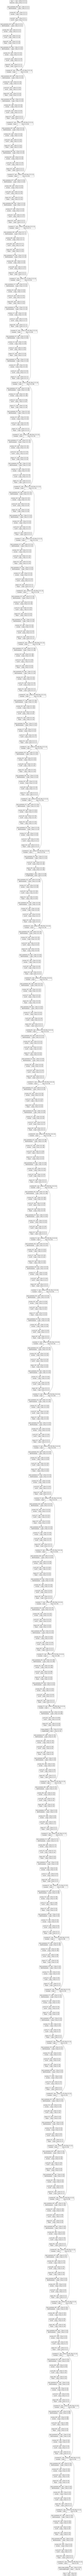

In [24]:
model = DenseNet(x_train.shape[1:],
             growth_rate = 12,
             num_blocks = 3,
             depth = 100,
             dropout_rate=0.2,
             compression_factor=0.5,
             bottleneck = True,
             compression = True,
             data_augmentation=False)
plot_model(model, show_shapes = True)

In [25]:
# According to the paper
def lr_schedule(epoch):
  lr = 1e-1
  if epoch >= 150:
    lr *= 0.1
  elif epoch >= 225:
    lr *= 0.1
  return lr

batch_size = 64
epochs = 300

save_dir = os.path.join(os.getcwd(), "save_models")
model_name = f"cifar10_denset_model" + ".{epoch:02d}.keras"
if not os.path.isdir(save_dir):
  os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# extra
checkpoint = keras.callbacks.ModelCheckpoint(filepath = filepath, monitor = "val_acc", verbose = 1, save_best_only = True)
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
lr_optimizer = keras.callbacks.ReduceLROnPlateau(factor = np.sqrt(0.1), cooldown = 0, patience = 5, min_lr = 0.5e-6)
callbacks = [checkpoint, lr_scheduler, lr_optimizer]

steps_per_epoch = math.ceil(len(x_train) / batch_size)

In [26]:
import tensorflow as tf
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(len(x_train)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.shuffle(len(x_val)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
train_dataset.element_spec, val_dataset.element_spec

((TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)),
 (TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)))

In [28]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate= 1e-1, momentum=0.9, nesterov=True, weight_decay=1e-4),
              metrics=['acc'])

history = model.fit(train_dataset, epochs = 300, validation_data = val_dataset, steps_per_epoch = steps_per_epoch, callbacks = callbacks)

Epoch 1/300
704/704 [==============================] - ETA: 0s - loss: 1.5098 - acc: 0.4496
Epoch 1: val_acc improved from -inf to 0.48240, saving model to /content/save_models/cifar10_denset_model.01.keras
704/704 [==============================] - 234s 271ms/step - loss: 1.5098 - acc: 0.4496 - val_loss: 1.9565 - val_acc: 0.4824 - lr: 0.1000
Epoch 2/300
704/704 [==============================] - ETA: 0s - loss: 1.1066 - acc: 0.6028
Epoch 2: val_acc did not improve from 0.48240
704/704 [==============================] - 187s 265ms/step - loss: 1.1066 - acc: 0.6028 - val_loss: 1.8046 - val_acc: 0.4368 - lr: 0.1000
Epoch 3/300
704/704 [==============================] - ETA: 0s - loss: 0.9535 - acc: 0.6624
Epoch 3: val_acc did not improve from 0.48240
704/704 [==============================] - 188s 267ms/step - loss: 0.9535 - acc: 0.6624 - val_loss: 4.8600 - val_acc: 0.3258 - lr: 0.1000
Epoch 4/300
704/704 [==============================] - ETA: 0s - loss: 0.8477 - acc: 0.7005
Epoch 4: va

KeyboardInterrupt: 

**I had to terminate the Google Colab Session As I Was Running Out Of The GPU resources Provied By Google**

In [31]:
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [32]:
from keras.models import load_model
final_model = load_model('/content/save_models/cifar10_denset_model.25.keras')
loss, accuracy = final_model.evaluate(test_dataset)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')
error_rate = 1 - accuracy
print(f"Error rate: {error_rate:.2%}")

157/157 [==============================] - 12s 56ms/step - loss: 0.5097 - acc: 0.8572
Test loss: 0.5097
Test accuracy: 0.8572
Error rate: 14.28%
